# Calculating overlap between two waveforms 

Simona Miller, LIGO SURF Summer 2018 
(Last edited: July 9, 2018)

In [1]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_td_waveform, get_fd_waveform

%matplotlib inline

import numpy as np
import scipy as sp

from matplotlib import pyplot as plt

## Function to calculate overlap

$$
Overlap = \frac{\langle\,a\,|\,b\,\rangle}{{\langle\,a\,|\,a\,\rangle}^{1/2}\,{\langle\,b\,|\,b\,\rangle}^{1/2}}
$$

where $ (\,a\,|\,b\,) $ is the noise weighted inner product of vectors a and b (defined below).

In [36]:
# Function to calculate the overlap of two vectors a and b (FFTs) with 
# respect to noise vector Sn (PSD); df = freq. bin size
# Note: a, b, and Sn must be same length

def Overlap(a, b, Sn, df):
    
    ab = InnerProduct(a, b, Sn, df)
    aa = InnerProduct(a, a, Sn, df)
    bb = InnerProduct(b, b, Sn, df)
    
    overlap_complex = (ab)/(np.sqrt(aa)*np.sqrt(bb))
    
    overlap = np.real(overlap_complex)
    
    return overlap

The noise weighted inner product of two vectors a and b is given by: 

$$
\langle\,a\,|\,b\,\rangle = 4 \Re \int_{0}^{\infty} \frac{\tilde{a}(f)\,\tilde{b^*}(f)}{S_n(f)} df
$$

In [29]:
# Function to calculate the noise weighted inner product of two vectors
# a and b (FFTs) with noise vector Sn (PSD); df = freq. bin size
# Note: a, b, and Sn must be same length

def InnerProduct(a, b, Sn, df):
    
    b_conj = np.conj(b)
    
    integrand = []
    
    for i in range(0,len(a)):
        intgrnd = a[i]*b_conj[i]/Sn[i]
        integrand.append(intgrnd)
            
    result = 4*np.sum(integrand)*df
    
    return result

## Noise PSD

Time around **GW150914** is stationary and Gaussian.  That means we can completely describe the (statistical) properties of the noise by the power spectral density. (aka employing a 0-parameter noise model)

In [4]:
merger = Merger("GW150914")

# Get the data from the Hanford detector
strain = merger.strain('H1')

# Remove the low frequency content and downsample the data to 2048Hz
strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048).crop(2, 2)

# Freq. bin size:
df = strain.delta_f
print "delta_f:", df

# Sample rate:
samp_rate = strain.sample_rate
print "Sample rate:", samp_rate

# Upper and lower freq. limits
f_lower = 20.
f_upper = 1024.

# Making PSD 
psd = strain.psd(4)
psd = interpolate(psd, df)
noise = inverse_spectrum_truncation(psd, 4 * samp_rate)

fs = noise.delta_f * np.arange(noise.data.size)

delta_f: 0.0357142857143
Sample rate: 2048


Text(0.5,1,u'Noise Curve')

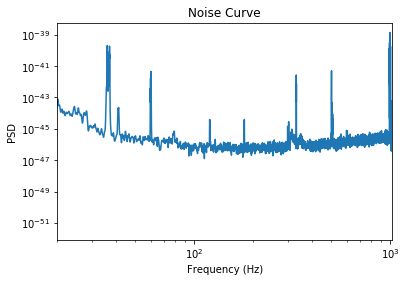

In [5]:
# Plotting noise curve
plt.loglog(fs, noise)
plt.xlim(f_lower, f_upper)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("Noise Curve")

## Waveforms

In [6]:
# In frequency domain... 

# Eccentricity of 0.000001 
hp1, hc1 = get_fd_waveform(approximant="EccentricFD",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/8192,
                         eccentricity=0.000001,
                         delta_f=0.001,
                         f_lower=f_lower, 
                         f_upper=f_upper)

# Eccentricity of 0.1 
hp2, hc2 = get_fd_waveform(approximant="EccentricFD",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/8192,
                         eccentricity=0.1,
                         delta_f=0.001,
                         f_lower=f_lower,
                         f_upper=f_upper)

/home/pycbc/pycbc-software/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


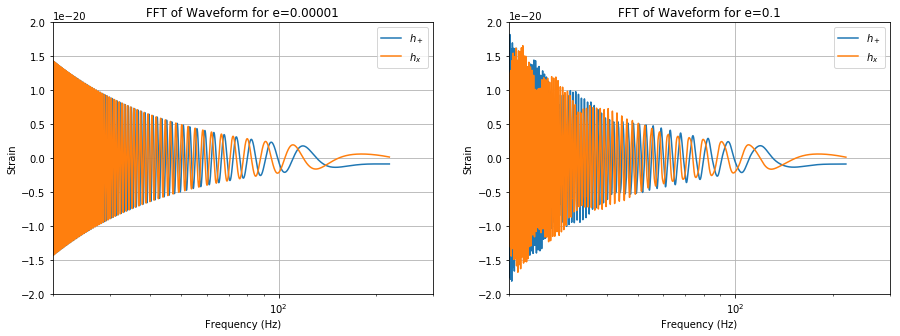

In [7]:
# Plotting FFTs

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.semilogx(hp1.sample_frequencies, hp1, label="$h_+$")
plt.semilogx(hc1.sample_frequencies, hc1, label="$h_x$")
plt.xlim(f_lower, 300)
plt.ylim(-2e-20,2e-20)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain")
plt.title("FFT of Waveform for e=0.00001")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.semilogx(hp2.sample_frequencies, hp2, label="$h_+$")
plt.semilogx(hc2.sample_frequencies, hc2, label="$h_x$")
plt.xlim(f_lower, 300)
plt.ylim(-2e-20,2e-20)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain")
plt.title("FFT of Waveform for e=0.1")
plt.grid()
plt.legend()

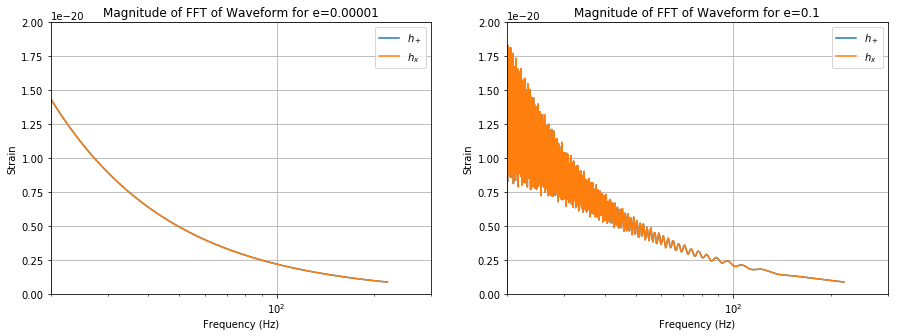

In [8]:
# Plotting Magnitude of FFTs

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.semilogx(hp1.sample_frequencies, np.abs(hp1), label="$h_+$")
plt.semilogx(hc1.sample_frequencies, np.abs(hc1), label="$h_x$")
plt.xlim(f_lower, 300)
plt.ylim(0,2e-20)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain")
plt.title("Magnitude of FFT of Waveform for e=0.00001")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.semilogx(hp2.sample_frequencies, np.abs(hp2), label="$h_+$")
plt.semilogx(hc2.sample_frequencies, np.abs(hc2), label="$h_x$")
plt.xlim(f_lower, 300)
plt.ylim(0,2e-20)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain")
plt.title("Magnitude of FFT of Waveform for e=0.1")
plt.grid()
plt.legend()

In [20]:
# Making all frequency series same length

df = hp1.delta_f 

noise_interp = interpolate(noise,df)
noise_interp_trimmed = noise_interp[:len(hp1)]

In [21]:
# Checking lengths
print len(noise_interp_trimmed)
print len(hp1)
print len(hp2)

219859
219859
219859


In [23]:
# Checking first and last indices
print noise_interp_trimmed.sample_frequencies[0], noise_interp_trimmed.sample_frequencies[-1]
print hp1.sample_frequencies[0], hp1.sample_frequencies[-1]
print hp2.sample_frequencies[0], hp2.sample_frequencies[-1]

0.0 219.858
0.0 219.858
0.0 219.858


## Calculating overlap between these two waveforms

In [38]:
overlap_plus = Overlap(hp1, hp2, noise_interp_trimmed, df)
overlap_cross = Overlap(hc1, hc2, noise_interp_trimmed, df)

print overlap_plus
print overlap_cross

0.931847358857
0.931847288699


## Overlap for waveforms with different eccentricities

In [39]:
ecc = [0.000001, 0.1, 0.2, 0.3, 0.4]

In [40]:
waveforms_hp = {} # dict for h+ waveforms
waveforms_hc = {} # dict for hx waveforms

for e in ecc: 
    
    key = e
    
    hp, hc = get_fd_waveform(approximant="EccentricFD",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/8192,
                         eccentricity=e,
                         delta_f=0.001,
                         f_lower=f_lower, 
                         f_upper=f_upper)
    
    waveforms_hp[key] = hp
    waveforms_hc[key] = hc

In [41]:
for e in ecc: 
    
    no_ecc_plus = waveforms_hp[ecc[0]]
    no_ecc_cross = waveforms_hc[ecc[0]]
    
    ecc_plus = waveforms_hp[e]
    ecc_cross = waveforms_hc[e]
    
    # h+ overlap with e=0.000001 and e=e
    overlap_plus = Overlap(no_ecc_plus, ecc_plus, noise_interp_trimmed, df)
    
    # hx overlap with e=0.000001 and e=e
    overlap_cross = Overlap(no_ecc_cross, ecc_cross, noise_interp_trimmed, df)
    
    print "Overlap of waveforms with e=0.000001 and e={}:\n h+:{}\t hx:{}\n\n".format(e,overlap_plus,overlap_cross)

Overlap of waveforms with e=0.000001 and e=1e-06:
 h+:1.0	 hx:1.0


Overlap of waveforms with e=0.000001 and e=0.1:
 h+:0.931847358857	 hx:0.931847288699


Overlap of waveforms with e=0.000001 and e=0.2:
 h+:0.753039666397	 hx:0.75303666052


Overlap of waveforms with e=0.000001 and e=0.3:
 h+:0.61527828584	 hx:0.615269716


Overlap of waveforms with e=0.000001 and e=0.4:
 h+:0.488408288935	 hx:0.488391258503


